In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ------------------------------------------------------------
# Utility: IQM (Interquartile Mean)
# ------------------------------------------------------------
def iqm(values):
    values = np.sort(np.asarray(values))
    n = len(values)
    lo = int(0.25 * n)
    hi = int(0.75 * n)
    if hi <= lo:
        return float(np.mean(values))
    return float(np.mean(values[lo:hi]))

# ------------------------------------------------------------
# Stage-2: Load G values = mean(avg_return for steps ≥ start_step)
# ------------------------------------------------------------
def collect_G_values_single_config(log_dir, start_step=900_000, file_suffixes=(".json", ".jso")):
    folder = Path(r"\\?\\" + str(Path(log_dir).resolve()))
    files = []
    for suf in file_suffixes:
        files += list(folder.glob(f"*{suf}"))

    print(f"\n🔍 Looking in: {folder}")
    print(f"Found {len(files)} logs.")
    if not files:
        raise FileNotFoundError("No logs found.")

    def load_curve(path):
        with path.open("r") as f:
            d = json.load(f)
        ev = [e for e in d["events"] if e["event"] == "train_episode"]
        steps = np.array([e["total_steps"] for e in ev])
        avg = np.array([e["average_return"] for e in ev])
        return steps, avg

    G_vals = []
    for p in files:
        steps, avg = load_curve(p)
        mask = steps >= start_step
        if np.any(mask):
            G_vals.append(float(np.nanmean(avg[mask])))

    G_vals = np.array(G_vals)
    summary = pd.DataFrame([{
        "Mean_G": np.mean(G_vals),
        "Std_G": np.std(G_vals),
        "Median_G": np.median(G_vals),
        "IQM_G": iqm(G_vals),
        "Num_Runs": len(G_vals)
    }])

    print("\n📊 Stage-2 Summary:")
    print(summary.to_string(index=False, float_format=lambda x: f"{x:,.2f}"))
    return G_vals, summary

# ------------------------------------------------------------
# Bootstrap CI for Mean Difference (PPO* – TRPO*)
# ------------------------------------------------------------
def bootstrap_mean_difference(G_A, G_B, B=10000, alpha=0.05, label_A="A", label_B="B"):
    G_A, G_B = np.asarray(G_A), np.asarray(G_B)
    obs = np.mean(G_A) - np.mean(G_B)

    boot = []
    for _ in range(B):
        A_s = np.random.choice(G_A, size=len(G_A), replace=True)
        B_s = np.random.choice(G_B, size=len(G_B), replace=True)
        boot.append(np.mean(A_s) - np.mean(B_s))
    boot = np.array(boot)

    lo, up = np.percentile(boot, [alpha/2*100, (1-alpha/2)*100])

    print("\n================ MEAN DIFFERENCE BOOTSTRAP ================")
    print(f"{label_A} - {label_B} mean difference = {obs:.2f}")
    print(f"{int((1-alpha)*100)}% CI: [{lo:.2f}, {up:.2f}]")
    if lo > 0: print(f"→ {label_A} significantly BETTER than {label_B}")
    elif up < 0: print(f"→ {label_A} significantly WORSE than {label_B}")
    else: print("→ No significant difference")

    return obs, (lo, up)

# ------------------------------------------------------------
# Bootstrap CI for IQM Difference
# ------------------------------------------------------------
def bootstrap_iqm_difference(G_A, G_B, B=10000, alpha=0.05, label_A="A", label_B="B"):
    G_A, G_B = np.asarray(G_A), np.asarray(G_B)
    obs = iqm(G_A) - iqm(G_B)

    boot = []
    for _ in range(B):
        A_s = np.random.choice(G_A, size=len(G_A), replace=True)
        B_s = np.random.choice(G_B, size=len(G_B), replace=True)
        boot.append(iqm(A_s) - iqm(B_s))
    boot = np.array(boot)

    lo, up = np.percentile(boot, [alpha/2*100, (1-alpha/2)*100])

    print("\n================ IQM DIFFERENCE BOOTSTRAP ================")
    print(f"IQM[{label_A}] - IQM[{label_B}] = {obs:.2f}")
    print(f"{int((1-alpha)*100)}% CI: [{lo:.2f}, {up:.2f}]")

    if lo > 0: print(f"→ {label_A} significantly BETTER (IQM)")
    elif up < 0: print(f"→ {label_A} significantly WORSE (IQM)")
    else: print("→ No significant difference in IQM")

    return obs, (lo, up)

# ------------------------------------------------------------
# CDF with bootstrap tolerance band
# ------------------------------------------------------------
def cdf_with_band(values, B=2000, num_points=200, alpha=0.05):
    values = np.asarray(values)
    xs = np.linspace(values.min(), values.max(), num_points)
    base_cdf = np.array([np.mean(values <= x) for x in xs])

    boots = []
    for _ in range(B):
        samp = np.random.choice(values, size=len(values), replace=True)
        boots.append([np.mean(samp <= x) for x in xs])
    boots = np.array(boots)

    lo = np.percentile(boots, alpha/2*100, axis=0)
    up = np.percentile(boots, (1-alpha/2)*100, axis=0)
    return xs, base_cdf, lo, up

def plot_cdf_comparison(G_A, G_B, label_A="A", label_B="B"):
    xsA, cdfA, loA, upA = cdf_with_band(G_A)
    xsB, cdfB, loB, upB = cdf_with_band(G_B)

    plt.figure(figsize=(8,6))
    plt.title("CDF Comparison", fontsize=14)

    # PPO* — blue
    plt.plot(xsA, cdfA, color="#1f77b4", linewidth=2, label=label_A)
    plt.fill_between(xsA, loA, upA, color="#1f77b4", alpha=0.2)

    # TRPO* — orange
    plt.plot(xsB, cdfB, color="#ff7f0e", linewidth=2, label=label_B)
    plt.fill_between(xsB, loB, upB, color="#ff7f0e", alpha=0.2)

    plt.xlabel("Final G (mean return ≥ start_step)")
    plt.ylabel("CDF  P(G ≤ x)")
    plt.grid(alpha=0.3, linestyle="--")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------
# Load full learning curves
# ------------------------------------------------------------
def load_full_learning_curves(log_dir, file_suffixes=(".json", ".jso")):
    folder = Path(r"\\?\\" + str(Path(log_dir).resolve()))
    files = []
    for suf in file_suffixes:
        files += list(folder.glob(f"*{suf}"))

    runs = []
    for p in files:
        with p.open("r") as f:
            d = json.load(f)
        ev = [e for e in d["events"] if e["event"] == "train_episode"]
        steps = np.array([e["total_steps"] for e in ev])
        avg = np.array([e["average_return"] for e in ev])
        if len(steps) > 0:
            runs.append((steps, avg))
    return runs

# ------------------------------------------------------------
# Align curves starting at step >= 900k
# ------------------------------------------------------------
def align_from_start(runs, start_step=900_000):
    aligned = []
    for steps, avg in runs:
        mask = steps >= start_step
        if not np.any(mask):
            continue
        aligned.append((steps[mask], avg[mask]))

    min_end = min(st[-1] for st, _ in aligned)
    x_common = np.linspace(start_step, min_end, 300)

    arr = []
    for st, av in aligned:
        arr.append(np.interp(x_common, st, av))
    return x_common, np.vstack(arr)

# ------------------------------------------------------------
# Plot post-900k learning curve
# ------------------------------------------------------------
def plot_learning_curve_from_900k(ppo_runs, trpo_runs, start_step=900_000, label_A="PPO*", label_B="TRPO*"):
    xA, arrA = align_from_start(ppo_runs, start_step)
    xB, arrB = align_from_start(trpo_runs, start_step)

    meanA = arrA.mean(axis=0)
    meanB = arrB.mean(axis=0)

    loA = np.percentile(arrA, 2.5, axis=0)
    upA = np.percentile(arrA, 97.5, axis=0)
    loB = np.percentile(arrB, 2.5, axis=0)
    upB = np.percentile(arrB, 97.5, axis=0)

    plt.figure(figsize=(10,6))
    plt.title("Learning Curve Comparison (Steps ≥ 900k)", fontsize=15)

    plt.plot(xA, meanA, color="#1f77b4", label=label_A, linewidth=2)
    plt.fill_between(xA, loA, upA, color="#1f77b4", alpha=0.2)

    plt.plot(xB, meanB, color="#ff7f0e", label=label_B, linewidth=2)
    plt.fill_between(xB, loB, upB, color="#ff7f0e", alpha=0.2)

    plt.xlabel("Total Environment Steps")
    plt.ylabel("Average Return")
    plt.grid(alpha=0.3, linestyle="--")
    plt.legend()
    plt.tight_layout()
    plt.show()



🔍 Looking in: \\?\\C:\Users\Phong\OneDrive\Documents\VSCODEFILE\CMPUT665-PROJECT\ppo_ant
Found 128 logs.

📊 Stage-2 Summary:
 Mean_G  Std_G  Median_G  IQM_G  Num_Runs
 249.98  70.63    240.13 243.72       128

🔍 Looking in: \\?\\C:\Users\Phong\OneDrive\Documents\VSCODEFILE\CMPUT665-PROJECT\trpo_ant
Found 96 logs.

📊 Stage-2 Summary:
 Mean_G  Std_G  Median_G  IQM_G  Num_Runs
  49.75  44.96     25.98  35.63        96

================ MEAN DIFFERENCE BOOTSTRAP ================
PPO* (Ant-v5) - TRPO* (Ant-v5) mean difference = 200.24
95% CI: [185.31, 215.36]
→ PPO* (Ant-v5) significantly BETTER than TRPO* (Ant-v5)

================ IQM DIFFERENCE BOOTSTRAP ================
IQM[PPO* (Ant-v5)] - IQM[TRPO* (Ant-v5)] = 208.09
95% CI: [187.79, 226.57]
→ PPO* (Ant-v5) significantly BETTER (IQM)


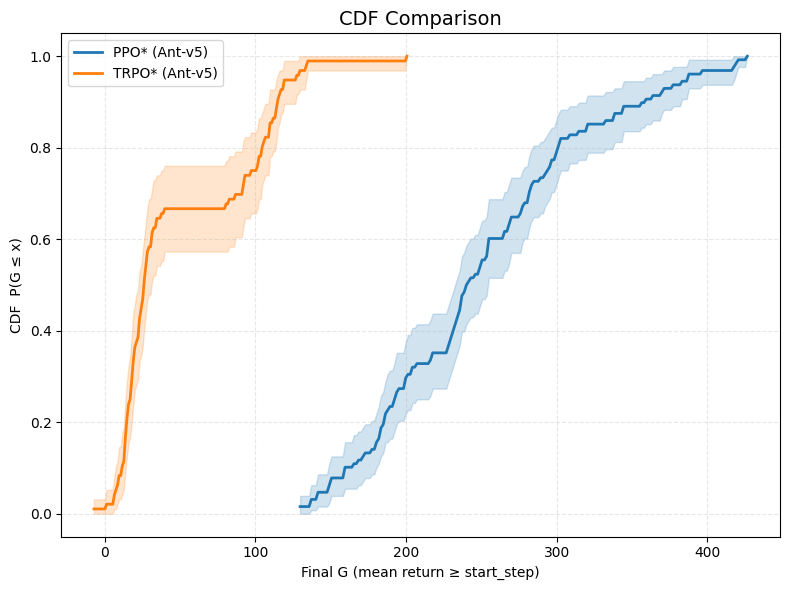

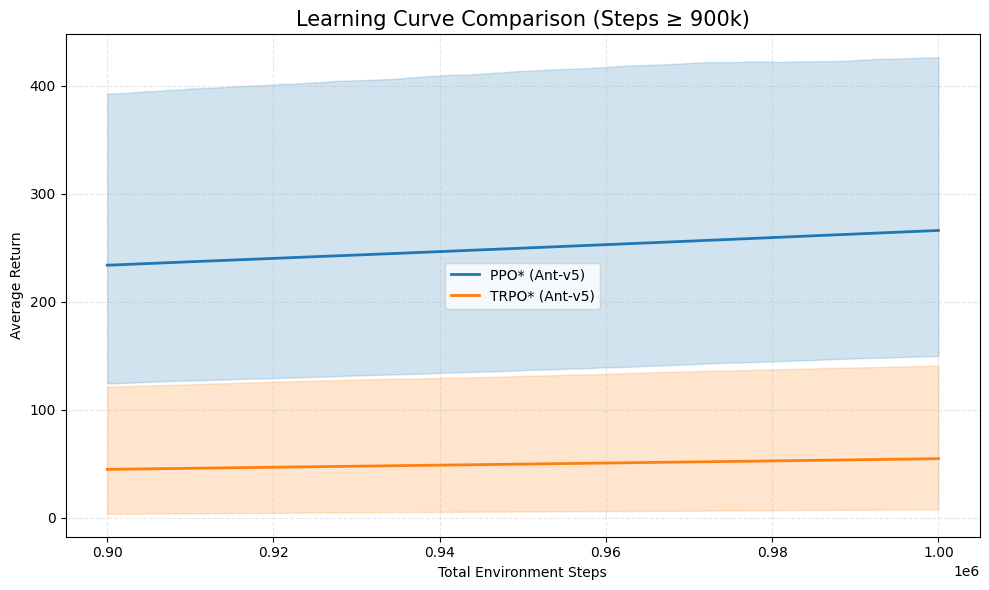

In [4]:
# Load G values for both tuned configs
G_ppo_ant, sum_ppo_ant = collect_G_values_single_config(
    log_dir=r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/ppo_ant",
    start_step=900_000,
)

G_trpo_ant, sum_trpo_ant = collect_G_values_single_config(
    log_dir=r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/trpo_ant",
    start_step=900_000,
)

# Bootstrap tests
bootstrap_mean_difference(G_ppo_ant, G_trpo_ant, B=10000,
                          label_A="PPO* (Ant-v5)", label_B="TRPO* (Ant-v5)")

bootstrap_iqm_difference(G_ppo_ant, G_trpo_ant, B=10000,
                         label_A="PPO* (Ant-v5)", label_B="TRPO* (Ant-v5)")

# CDF plot
plot_cdf_comparison(G_ppo_ant, G_trpo_ant,
                    label_A="PPO* (Ant-v5)", label_B="TRPO* (Ant-v5)")

# Learning curve plot (steps ≥ 900k)
ppo_runs_ant = load_full_learning_curves(
    r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/ppo_ant"
)
trpo_runs_ant = load_full_learning_curves(
    r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/trpo_ant"
)
plot_learning_curve_from_900k(ppo_runs_ant, trpo_runs_ant,
                              start_step=900_000,
                              label_A="PPO* (Ant-v5)", label_B="TRPO* (Ant-v5)")


In [5]:
import numpy as np
import matplotlib.pyplot as plt


# ============================================================
# Compute empirical CDF
# ============================================================
def empirical_cdf(values, num_points=200):
    values = np.asarray(values)
    xs = np.linspace(0, 1, num_points)
    cdf = np.array([np.mean(values <= x) for x in xs])
    return xs, cdf


# ============================================================
# Normalize scores for a single environment (PPO & TRPO)
# ============================================================
def normalize_env(G_ppo_env, G_trpo_env):
    """
    Normalize scores to [0,1] using min/max of BOTH algorithms for this env.
    """
    all_scores = np.concatenate([G_ppo_env, G_trpo_env])
    min_s = np.min(all_scores)
    max_s = np.max(all_scores)

    # Avoid divide-by-zero if env has zero variance
    if max_s - min_s < 1e-9:
        return (
            np.zeros_like(G_ppo_env),
            np.zeros_like(G_trpo_env),
        )

    norm_ppo  = (G_ppo_env  - min_s) / (max_s - min_s)
    norm_trpo = (G_trpo_env - min_s) / (max_s - min_s)

    return norm_ppo, norm_trpo


# ============================================================
# Multi-Environment Normalized Performance Profile
# ============================================================
def normalized_cdf_all_envs(
    G_ppo_dict,
    G_trpo_dict,
    label_A="PPO*",
    label_B="TRPO*"
):
    """
    Inputs:
        G_ppo_dict  = {"Ant": G_ppo_ant, "Cheetah": G_ppo_chet, ...}
        G_trpo_dict = {"Ant": G_trpo_ant, "Cheetah": G_trpo_chet, ...}

    Automatically:
        - normalizes per env
        - aggregates all envs
        - plots normalized CDF
    """

    ppo_all = []
    trpo_all = []

    # Normalize each environment separately
    for env in G_ppo_dict.keys():

        G_ppo_env  = np.asarray(G_ppo_dict[env])
        G_trpo_env = np.asarray(G_trpo_dict[env])

        norm_ppo, norm_trpo = normalize_env(G_ppo_env, G_trpo_env)

        ppo_all.append(norm_ppo)
        trpo_all.append(norm_trpo)

        print(f"✓ Normalized environment: {env} "
              f"({len(G_ppo_env)} PPO runs, {len(G_trpo_env)} TRPO runs)")

    # Concatenate ALL environments
    ppo_all = np.concatenate(ppo_all)
    trpo_all = np.concatenate(trpo_all)

    # Compute aggregated CDFs
    xs, cdf_ppo  = empirical_cdf(ppo_all)
    _,  cdf_trpo = empirical_cdf(trpo_all)

    # Plot
    plt.figure(figsize=(9, 6))

    plt.plot(xs, cdf_ppo, color="#1f77b4", linewidth=2.2, label=label_A)
    plt.plot(xs, cdf_trpo, color="#ff7f0e", linewidth=2.2, label=label_B)

    plt.title("Multi-Environment Normalized Performance Profile", fontsize=15)
    plt.xlabel("Normalized Score (0–1)")
    plt.ylabel("Fraction of Runs ≤ Score (CDF)")
    plt.grid(alpha=0.3, linestyle="--")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [6]:
# Ant-v5 G-values
G_ppo_ant, _ = collect_G_values_single_config(
    log_dir=r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/ppo_ant",
    start_step=900_000,
)

G_trpo_ant, _ = collect_G_values_single_config(
    log_dir=r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/trpo_ant",
    start_step=900_000,
)


# HalfCheetah-v5 G-values
G_ppo_chet, _ = collect_G_values_single_config(
    log_dir=r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/ppo_chet",
    start_step=900_000,
)

G_trpo_chet, _ = collect_G_values_single_config(
    log_dir=r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/trpo_chet",
    start_step=900_000,
)



🔍 Looking in: \\?\\C:\Users\Phong\OneDrive\Documents\VSCODEFILE\CMPUT665-PROJECT\ppo_ant
Found 128 logs.

📊 Stage-2 Summary:
 Mean_G  Std_G  Median_G  IQM_G  Num_Runs
 249.98  70.63    240.13 243.72       128

🔍 Looking in: \\?\\C:\Users\Phong\OneDrive\Documents\VSCODEFILE\CMPUT665-PROJECT\trpo_ant
Found 96 logs.

📊 Stage-2 Summary:
 Mean_G  Std_G  Median_G  IQM_G  Num_Runs
  49.75  44.96     25.98  35.63        96

🔍 Looking in: \\?\\C:\Users\Phong\OneDrive\Documents\VSCODEFILE\CMPUT665-PROJECT\ppo_chet
Found 128 logs.

📊 Stage-2 Summary:
  Mean_G  Std_G  Median_G    IQM_G  Num_Runs
1,578.24 519.15  1,651.07 1,618.31       128

🔍 Looking in: \\?\\C:\Users\Phong\OneDrive\Documents\VSCODEFILE\CMPUT665-PROJECT\trpo_chet
Found 96 logs.

📊 Stage-2 Summary:
  Mean_G  Std_G  Median_G  IQM_G  Num_Runs
1,072.42 567.62    930.13 946.31        96


In [7]:
G_ppo_dict = {
    "Ant-v5":         G_ppo_ant,
    "HalfCheetah-v5": G_ppo_chet,
}

G_trpo_dict = {
    "Ant-v5":         G_trpo_ant,
    "HalfCheetah-v5": G_trpo_chet,
}


✓ Normalized environment: Ant-v5 (128 PPO runs, 96 TRPO runs)
✓ Normalized environment: HalfCheetah-v5 (128 PPO runs, 96 TRPO runs)


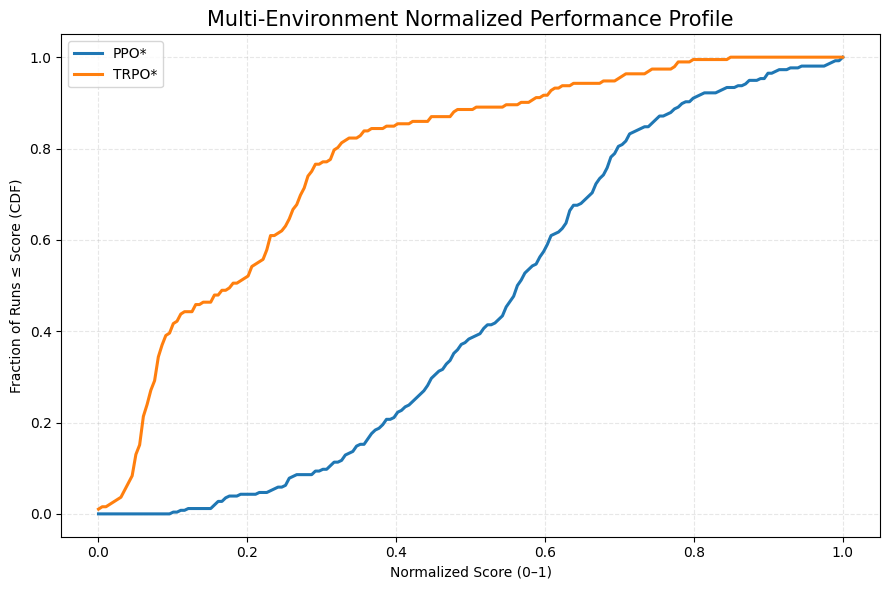

In [8]:
normalized_cdf_all_envs(G_ppo_dict, G_trpo_dict)
